The web traffic and protocol attacks in this dataset were created inside an isolated network of virtual machines. While capturing traffic with Wireshark, I used the Scapy library to execute ARP Spoofing as well as SYN, FIN and Xmas port scans with the idea in mind of viewing the network traffic in Pandas. Here we can find the information that identifies malicious packets for our use cases.

In [3]:
import pandas as pd
import numpy as np
import pandas as pd
from google.colab import files
import io
import matplotlib.pyplot as plt
import plotly.express as px
up = files.upload()

Saving scans.csv to scans (1).csv


In [185]:
df = pd.read_csv(io.BytesIO(up['scans.csv']), parse_dates = ['Time'])
df.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,2023-03-09 22:08:56.181713021,192.168.1.101,192.168.1.1,DNS,84,Standard query 0xd60b A engineering.virginia.edu
1,2,2023-03-09 22:08:56.182232092,192.168.1.101,192.168.1.1,DNS,84,Standard query 0x0e0f AAAA engineering.virgini...
2,3,2023-03-09 22:08:59.851676016,192.168.1.100,192.168.1.255,BROWSER,286,"Local Master Announcement METASPLOITABLE, Work..."
3,4,2023-03-09 22:08:59.852203395,192.168.1.100,192.168.1.255,BROWSER,257,"Domain/Workgroup Announcement WORKGROUP, NT Wo..."
4,5,2023-03-09 22:09:01.188195767,192.168.1.101,192.168.1.1,DNS,84,Standard query 0xd60b A engineering.virginia.edu


####In a continuum of internet protocol packets, each is comprised of information which identifies its purpose. A specific probe or scan will innately produce a certain type of traffic, which can be filtered programatically.

- Adding columns to indicate presence of TCP flags used in probes
- Subsetting the dataframe by protocol

In [186]:
mask_1 = df['Info'].str.contains('SYN') & ~df['Info'].str.contains('ACK')
mask_2 = df['Info'].str.contains('FIN') & ~df['Info'].str.contains('PSH')
mask_3 = df['Info'].str.contains('FIN') & df['Info'].str.contains('PSH') & \
         df['Info'].str.contains('URG')
mask_4 = ~mask_1 & ~mask_2 & ~mask_3
df.loc[mask_1, 'SYN'] = 1
df.loc[mask_1, 'Scan_Type'] = 'SYN'
df.loc[~mask_1, 'SYN'] = 0
df.loc[mask_2, 'FIN'] = 1
df.loc[mask_2, 'Scan_Type'] = 'FIN'
df.loc[~mask_2, 'FIN'] = 0
df.loc[mask_3, 'XMAS'] = 1
df.loc[mask_3, 'Scan_Type'] = 'Xmas'
df.loc[~mask_3, 'XMAS'] = 0
df.loc[mask_4, 'Scan_Type'] = 'None'
syn = df.loc[df['SYN'] > 0]
fin = df.loc[df['FIN'] > 0]
xmas = df.loc[df['XMAS'] > 0]
arp = df.loc[df['Protocol'] == 'ARP']
tcp = df.loc[df['Protocol'] == 'TCP']
icmp = df.loc[df['Protocol'] == 'ICMP']
dns = df.loc[df['Protocol'] == 'DNS']
start = df.Time.min()
ending = df.Time.max()
strt_syn = syn.Time.min()
end_syn = syn.Time.max()
strt_fin = fin.Time.min()
end_fin = fin.Time.max()
strt_xmas = xmas.Time.min()
end_xmas = xmas.Time.max()
elapsed = (ending - start).seconds
dur_syn = (end_syn - strt_syn).seconds
dur_fin = (end_fin - strt_fin).seconds
dur_xmas = (end_xmas - strt_xmas).seconds
print(f'Total Packet Capture: {len(df)}\nTotal Capture Time: {elapsed} seconds')
for protocol in df['Protocol'].unique():
    l = len(df[df['Protocol'] == protocol])
    print(f'{protocol}: {l}')

Total Packet Capture: 1481
Total Capture Time: 149 seconds
DNS: 76
BROWSER: 2
ARP: 746
DHCPv6: 2
ICMP: 6
TCP: 649


In [187]:
fig = px.histogram(df.loc[df['Scan_Type'] != 'None'],
                   x = 'Scan_Type',
                   title = '# Packets Sent / Scan Type')
fig.show()

During the traffic capture, the SYN and FIN scans both sent 100 packets to 100 ports, and the Xmas scan sent 126 packets to 126 ports. The SYN scan took four seconds to complete, the FIN scan took nine, and the Xmas scan twenty-three. For a brief period, FIN and Xmas scans ran concurrently, creating possibly increased latency for these scripts. The code below pulls the rate at which each scan sent its probes.

In [188]:
def avg_probe_frequency(df):
    # returns average length in seconds between observations in df
    times = df['Time']
    spaces = []
    for i in range(1, len(times)):
        a, b = times.iloc[i - 1], times.iloc[i]
        spaces.append((b - a).microseconds)
    return sum(spaces) / len(spaces) / 1000000

In [189]:
avg_time_btwn_syn = avg_probe_frequency(syn)
avg_time_btwn_fin = avg_probe_frequency(fin)
avg_time_btwn_xmas = avg_probe_frequency(xmas)
print(f'Average of {avg_time_btwn_syn} seconds between each syn scan packet')
print(f'Average of {avg_time_btwn_fin} seconds between each fin scan packet')
print(f'''Average of {avg_time_btwn_xmas} seconds between each fin-psh-urg scan
  packet'''.replace('\n ', ''))

Average of 0.04133431 seconds between each syn scan packet
Average of 0.03911318 seconds between each fin scan packet
Average of 0.04071980158730159 seconds between each fin-psh-urg scan packet


Using an algorithm to search the dataset for the beginning, duration, and end of an ARP Spoof

In [190]:
i = 0
spoof_strt = 0
spoof_end = 0
total_spoof_pkts = 0
spoofing = False
while i < len(df) - 4:
    a = df.loc[i: i + 4, :]
    plst = list(set(a['Protocol']))
    if not spoofing:
        if len(plst) == 1 and plst[0] == 'ARP':
            pkts = [a.iloc[0], a.iloc[2]]
            if all(pkt['Info'].startswith('Who has') for pkt in pkts):
                spoof_strt = pkts[0]['Time']
                spoofing = True
                total_spoof_pkts = i + 1
    else:
        if not 'ARP' in plst:
            spoof_end = df.loc[i - 1]['Time']
            total_spoof_pkts = i - total_spoof_pkts
            break
        if i + 4 == len(df) - 1:
            a1 = a.loc[a['Protocol'] == 'ARP']
            spoof_end = a1.max(key = lambda x: x.index)['Time']
            for j in range(len(a1)):
                info = a1.iloc[j]['Info']
                if info.startswith('Who has'):
                    total_spoof_pkts += 1
            total_spoof_pkts = i - total_spoof_pkts
        elif a.iloc[0]['Info'].startswith('Who has'):
            total_spoof_pkts += 1
    i += 1
print(f'Start of ARP Spoof: {spoof_strt}')
print(f'End of ARP Spoof: {spoof_end}')
print(f'ARP Spoof duration: {(spoof_end - spoof_strt).seconds} seconds')
print(f'ARP Spoof packets: {total_spoof_pkts}')

Start of ARP Spoof: 2023-03-09 22:09:49.344534903
End of ARP Spoof: 2023-03-09 22:10:20.850098627
ARP Spoof duration: 31 seconds
ARP Spoof packets: 739


#Six protocols in use

- ARP(Address Resolution Protocol): Requests for ARP Table information; responses providing ARP Table information
- TCP(Transmission Control Protocol):  SYN, FIN, and XMAS scans
- DNS(Domain Name System): Requests to a DNS server
- ICMP(Internet Control Messaging Protocol): Pings and other messaging services
- DHCPv6(Dynamic Host Configuration Protocol): Assigns IPv6 addresses statefully and distributes information such as domain name or DNS server
- BROWSER: Used to discover machines and resources on the network

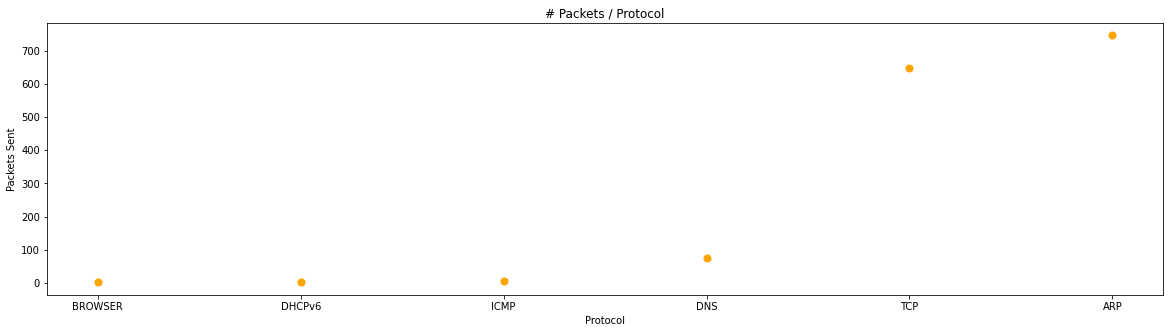

In [191]:
plt.figure(figsize = (20, 5))
pvc = df['Protocol'].value_counts(ascending = True)
plt.scatter(pvc.index, pvc, color = 'orange', s = 50)
plt.xlabel('Protocol')
plt.ylabel('Packets Sent')
plt.title('# Packets / Protocol')
plt.show()

In [192]:
fig = px.scatter(df, x = 'Time',
                 y = 'Protocol',
                 title = 'Time / Protocol')
fig.show()

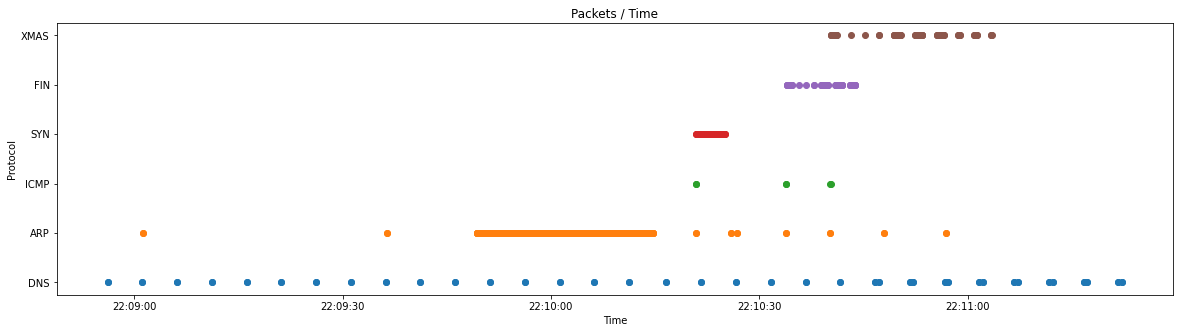

In [193]:
plt.figure(figsize = (20, 5))
plt.scatter(dns['Time'], dns['Protocol'])
plt.scatter(arp['Time'], arp['Protocol'])
plt.scatter(icmp['Time'], icmp['Protocol'])
plt.scatter(syn['Time'], ['SYN'] * len(syn))
plt.scatter(fin['Time'], ['FIN'] * len(fin))
plt.scatter(xmas['Time'], ['XMAS'] * len(xmas))
plt.xlabel('Time')
plt.ylabel('Protocol')
plt.title('Packets / Time')
plt.show()

The graph above paints a picture of the web traffic captured. We can see continuous DNS packets, an interval of ARP queries broken by a 30 second ARP spoof, and the three port scans mentioned earlier. One thing worth noting is after the ARP spoof and during the port probe attacks, the interval of ARP queries became much smaller.

In [194]:
spoof = arp.loc[(arp['Time'] >= spoof_strt) & (arp['Time'] <= spoof_end)]
avg_time_btwn_arp = avg_probe_frequency(spoof)
print(f'ARP Table information was sent to the network every {avg_time_btwn_arp}\
  seconds on average during the spoof'.replace('\n', '').replace('  ', ' '))

ARP Table information was sent to the network every 0.03498656378600823 seconds on average during the spoof


####During ARP Spoofing, an unknown MAC address creating the majority of ARP traffic is visible alongside client and server MAC addresses. The victimized server and client see spikes in received traffic.

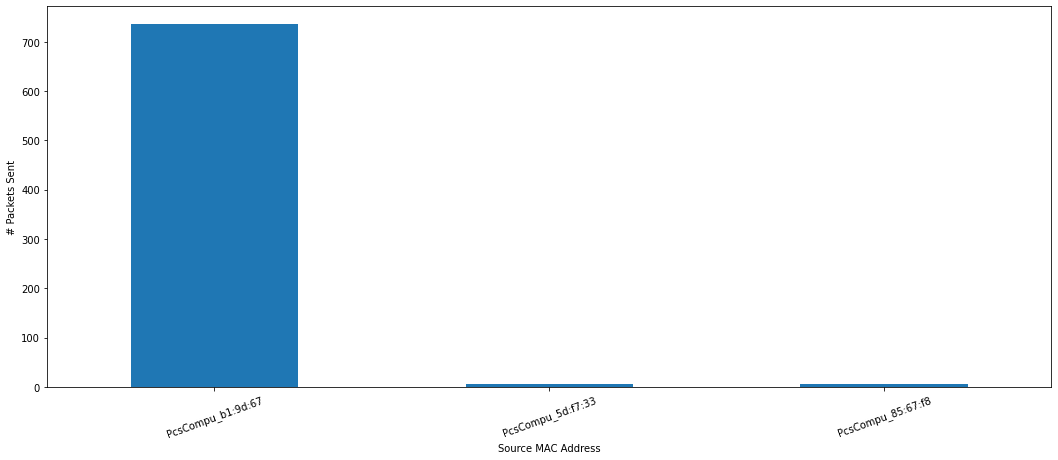

In [195]:
plt.figure(figsize = (18, 7))
arp['Source'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = 20)
plt.xlabel('Source MAC Address')
plt.ylabel('# Packets Sent')
plt.show()

Identifying network interface card number b1:9d:67 as the machine creating ARP traffic every 0.03498656378600823 seconds

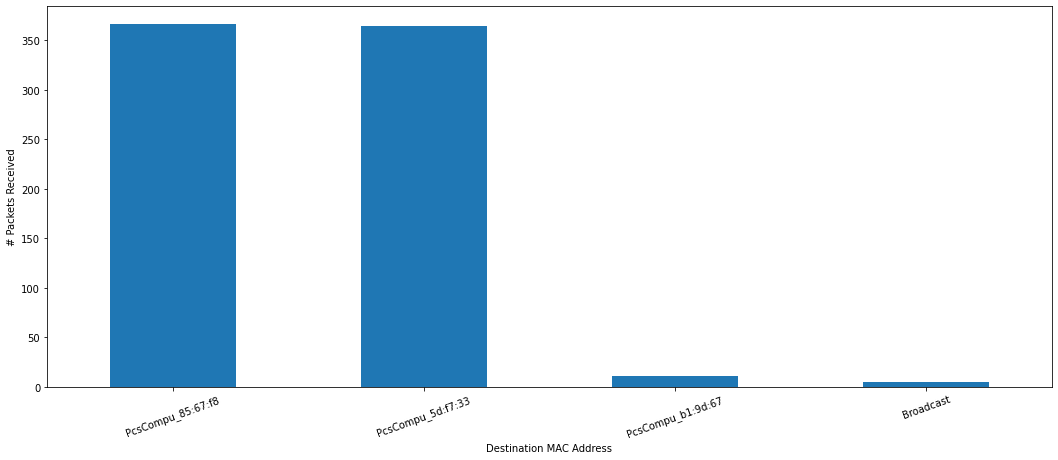

In [196]:
plt.figure(figsize = (18, 7))
arp['Destination'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = 20)
plt.xlabel('Destination MAC Address')
plt.ylabel('# Packets Received')
plt.show()

During the traffic capture that lasted 2 minutes and 29 seconds, a total of 1481 packets were captured. The 31 second ARP attack sent 739 packets to the network, while the three TCP port scans generated 329 request packets(101 packets for each scan plus 26 packets for the Xmas scan), and 320 response packets(six RST, six SYN-ACK, and 308 RST-ACK).

In [197]:
# account for all tcp packets
tcp_mask = ~tcp['Info'].str.contains('ACK') & ~tcp['Info'].str.contains('RST')
tcp_scans = tcp.loc[tcp_mask]
tcp_scans_2 = pd.concat([syn, fin, xmas])
if len(tcp_scans) == len(tcp_scans_2):
    print(f'Total of {len(tcp_scans)} port probes sent')
    c = 1
    probe_count = 0
    drops = []
    while c < 102:
        probes = tcp_scans[tcp_scans['Info'].str.contains(f' {str(c)} ')]
        probe_count += len(probes)
        drops.extend(probes.index)
        c += 1
    tcp3 = tcp_scans.drop(drops)
    tcp_eq = tcp_scans.sort_values('No.') == tcp_scans_2.sort_values('No.')
    print(tcp_eq.sum().unique()[0], tcp_eq.sum().nunique())
    print(probe_count + len(tcp3))
else:
    print('Error: Inaccurate ARP packet count')

Total of 329 port probes sent
329 1
329


In [199]:
# find if any ICMP packets were sent during the attacks
syn_mask = lambda x: (x >= strt_syn) and (x <= end_syn)
fin_mask = lambda x: (x >= strt_fin) and (x <= end_fin)
xmas_mask = lambda x: (x >= strt_xmas) and (x <= end_xmas)
spoof_mask = lambda x: (x >= spoof_strt) and (x <= spoof_end)
k = [(syn_mask, 'Syn'), (fin_mask, 'Fin'),
     (xmas_mask, 'Xmas'), (spoof_mask, 'Arp')]
for x in range(len(icmp)):
    row = icmp.iloc[x]
    num = row['No.']
    for mask in k:
        if mask[0](row['Time']):
            print(f'Packet No. {num} sent during {mask[1]} attack')
            break
    else:
      print(f'Packet No. {num} sent when no attacks were running')

Packet No. 772 sent when no attacks were running
Packet No. 773 sent when no attacks were running
Packet No. 994 sent when no attacks were running
Packet No. 995 sent when no attacks were running
Packet No. 1101 sent during Fin attack
Packet No. 1102 sent during Fin attack
